# Dhruv Rana #

## PART 1 ##

In [30]:
import glob
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

# Using my GPU to accelrate the results

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Classify Images ####

In [31]:
# sorted alphabatically
true_label = ['vending_machine' , 'vending_machine', 'golfcart', 'golfcart' , 'otter', 'otter' , 'basketball' , 'basketball',
              'cannon','cannon']
true_label = sorted (true_label)

label = true_label[::2]

predicted_label = []

# sorted alphabatically
# place all image in data folder
images = glob.glob('data\\*.jpg')
images = sorted(images)

model = ResNet50(weights='imagenet')

if(len(tf.config.experimental.list_physical_devices('GPU')) !=0 ):
    with tf.device('/GPU:0'):

        for filename in images :
            img = load_img(filename, target_size=(224, 224))
            img_arr = img_to_array(img)
            img_batch = np.expand_dims(img_arr, axis=0)
            img_processed = preprocess_input(img_batch)

            prediction = model.predict(img_processed)
            prediction = np.array(decode_predictions(prediction,top=3))
            
            predicted_label.append(prediction[0,0,1])
            print('Predicted for ' + filename + ' :', prediction[0,0,1])
           
            
else :

    for filename in images :
        img = load_img(filename, target_size=(224, 224))
        img_arr = img_to_array(img)
        img_batch = np.expand_dims(img_arr, axis=0)
        img_processed = preprocess_input(img_batch)

        prediction = model.predict(img_processed)
        prediction = np.array(decode_predictions(prediction,top=1))
            
        predicted_label.append(prediction[0,0,1])
        print('Prediction for ' + filename + ' :', prediction[0,0,1])

1/1 [==============================] - 1s 535ms/step
Predicted for data\basketball1.jpg : basketball
1/1 [==============================] - 0s 19ms/step
Predicted for data\basketball2.jpg : basketball
1/1 [==============================] - 0s 19ms/step
Predicted for data\cannon1.jpg : cannon
1/1 [==============================] - 0s 19ms/step
Predicted for data\cannon2.jpg : cannon
1/1 [==============================] - 0s 20ms/step
Predicted for data\golfcart1.jpg : golfcart
1/1 [==============================] - 0s 19ms/step
Predicted for data\golfcart2.jpg : golfcart
1/1 [==============================] - 0s 21ms/step
Predicted for data\otter1.JPG : otter
1/1 [==============================] - 0s 19ms/step
Predicted for data\otter2.jpg : otter
1/1 [==============================] - 0s 18ms/step
Predicted for data\vendingmachine1.jpg : vending_machine
1/1 [==============================] - 0s 18ms/step
Predicted for data\vendingmachine2.jpg : vending_machine


#### Results ####

In [32]:
cf_matrix = confusion_matrix(true_label,predicted_label)

df = pd.DataFrame(cf_matrix, index = label, columns=label)
print("\nConfusion Matrix :-")
print(df.to_markdown())

accuracy = accuracy_score(true_label,predicted_label)
precison = precision_score(true_label,predicted_label,labels=label, average='micro')
recall = recall_score(true_label,predicted_label,labels=label, average='micro')
f_score = f1_score(true_label,predicted_label,labels=label, average='micro')

print ("\naccuray : {0}%".format(accuracy*100))
print ("precison : {0}%".format(precison*100))
print ("recall : {0}%".format(recall*100))
print ("f-score : {0}%".format(f_score*100))


Confusion Matrix :-
|                 |   basketball |   cannon |   golfcart |   otter |   vending_machine |
|:----------------|-------------:|---------:|-----------:|--------:|------------------:|
| basketball      |            2 |        0 |          0 |       0 |                 0 |
| cannon          |            0 |        2 |          0 |       0 |                 0 |
| golfcart        |            0 |        0 |          2 |       0 |                 0 |
| otter           |            0 |        0 |          0 |       2 |                 0 |
| vending_machine |            0 |        0 |          0 |       0 |                 2 |

accuray : 100.0%
precison : 100.0%
recall : 100.0%
f-score : 100.0%


## PART 2 ##

In [33]:
import time
import copy

import numpy as np
import pandas as pd

import tensorflow as tf

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import models, datasets, transforms

import matplotlib.pyplot as plt
from PIL import Image



if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


##### Model Settings #######

In [34]:
LEARNING_RATE = 0.001

BATCH_SIZE = 128
NUM_EPOCHS = 10

NUM_INPUTS = 1*28*28 # grayscale (1-channel) 28*28 picture
NUM_CLASSES = 10 # digits 0 to 9

##### Load MNIST Dataset #######

In [35]:
train_data = datasets.MNIST(
    root="dataset",
    train=True,
    download=True,
    transform= transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="dataset",
    train=False,
    download=True,
    transform= transforms.ToTensor()
)

train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

CLASSES = train_data.classes

#### Change Fully Connected Layer ####

In [36]:
resnet18 = models.resnet18(pretrained=True)

print(resnet18.conv1)
print(resnet18.fc)

# we only need 10 classes need to cahnge ouput layer
# we also need to chnage so it takes 1 cahnnel instead of three channels
resnet18.fc = nn.Linear(resnet18.fc.in_features,NUM_CLASSES)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
print()
print(resnet18.conv1)
print(resnet18.fc)

# Make sure to send our model to GPU if available
resnet18 = resnet18.to(DEVICE)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=1000, bias=True)

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=10, bias=True)


c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Compare True Label w/ Predicted Label #####

In [37]:
def compute_accuracy (model, data_loader, device):
    model = model.to(device)
    model = model.eval() # put the model to evaultion mode
    
    num_correct_prediction = 0
    num_total_labels = 0
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            probabilities = resnet18(inputs.to(DEVICE))
            predicted_class = torch.argmax(probabilities, dim=1) # Class predicted by model
            
            num_total_labels += labels.size()[0]
            num_correct_prediction += (predicted_class == labels).sum()

    return num_correct_prediction/num_total_labels * 100

#### Test w/o training ####

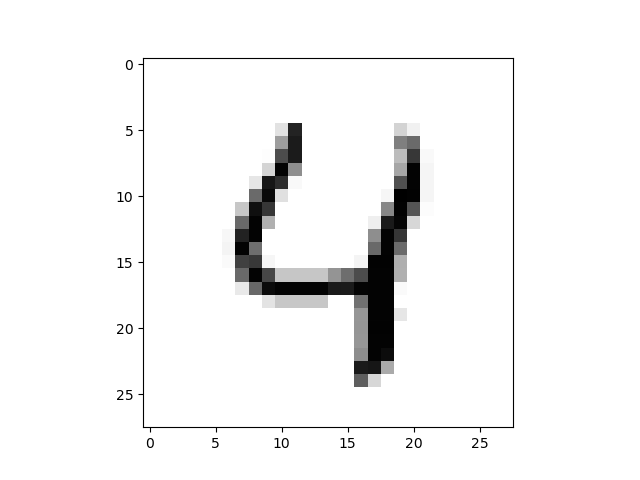

Predicted Num : 8
Actual Num : 4

Total Accuracy on test data : 12.890%


In [38]:
%matlplotlib inline

for batch_index, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break
    

    
img = np.transpose(inputs[4], axes=(1, 2, 0))
img = np.squeeze(img.numpy(), axis=2)
plt.imshow(img, cmap='Greys')
plt.show()



resnet18 = resnet18.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = resnet18(inputs.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Num : {:d}".format(predicted_class[4]))
print("Actual Num : {:d}".format(labels[4]))
print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))

#### Train Model ####

In [39]:
def train_model (model, data_loader, learning_rate, num_epochs, device):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    
    start_time = time.time()
    
    for epochs in range(num_epochs):
        
        print("EPOCH : {0}/{1}".format(epochs+1,num_epochs))
        print("-"*30)
        
        # train first
        model.train()
        for batch_index, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)   
             
            probabilities = resnet18(inputs)
            predicted_class = torch.argmax(probabilities, dim=1)
            
            optimizer.zero_grad()
            loss = nn.functional.cross_entropy(probabilities,labels)
                
            loss.backward()
            optimizer.step()
            #scheduler.step()
            
            if (batch_index % 50 == 0) :
                print("BATCH : {:3d}/{:3d} | LOSS : {:.3f} ".format(batch_index,len(data_loader),loss))
            
        
        # evalute
        model.eval()
        with torch.set_grad_enabled(False):
            accuracy = compute_accuracy(model,data_loader,DEVICE)
            print("\nTotal Accuracy On Training Data : {:.3f}%".format(accuracy))
        
        # Save best weights
        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_weights = copy.deepcopy(model.state_dict())
        
        print("Elapsed Time : {:.0f} min {:.0f} sec\n".format((time.time() - start_time)/60 , (time.time() - start_time)%60)) 
    
    print("\nTotal Time : {:.0f} min {:.0f} sec".format((time.time() - start_time)/60 , (time.time() - start_time)%60))
    
    
    model.load_state_dict(best_weights)
    return model

In [40]:
resnet18 = train_model(resnet18,train_loader,LEARNING_RATE,NUM_EPOCHS,DEVICE)

EPOCH : 1/10
------------------------------
BATCH :   0/469 | LOSS : 2.713 
BATCH :  50/469 | LOSS : 1.912 
BATCH : 100/469 | LOSS : 1.529 
BATCH : 150/469 | LOSS : 1.156 
BATCH : 200/469 | LOSS : 1.069 
BATCH : 250/469 | LOSS : 0.844 
BATCH : 300/469 | LOSS : 0.614 
BATCH : 350/469 | LOSS : 0.633 
BATCH : 400/469 | LOSS : 0.681 
BATCH : 450/469 | LOSS : 0.611 

Total Accuracy On Training Data : 86.847%
Elapsed Time : 0 min 20 sec

EPOCH : 2/10
------------------------------
BATCH :   0/469 | LOSS : 0.388 
BATCH :  50/469 | LOSS : 0.456 
BATCH : 100/469 | LOSS : 0.359 
BATCH : 150/469 | LOSS : 0.303 
BATCH : 200/469 | LOSS : 0.295 
BATCH : 250/469 | LOSS : 0.348 
BATCH : 300/469 | LOSS : 0.318 
BATCH : 350/469 | LOSS : 0.311 
BATCH : 400/469 | LOSS : 0.265 
BATCH : 450/469 | LOSS : 0.303 


### Test w/ Training ###

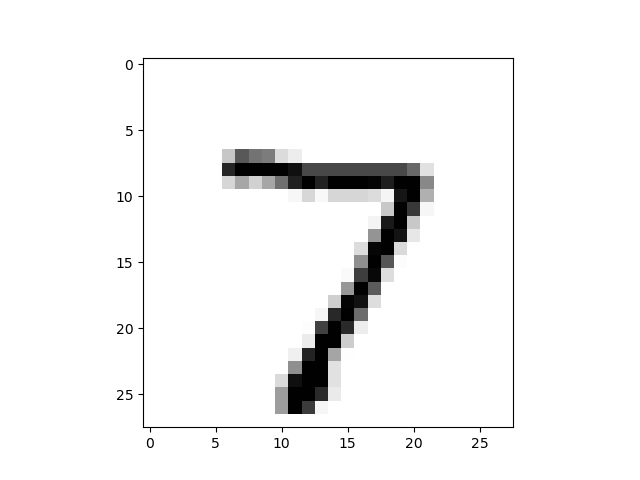

Predicted Num : 7
Actual Num : 7

Total Accuracy on test data : 97.650%


In [ ]:
%matlplotlib inline
features = torch.empty(0)
true_label = torch.empty(0)

for batch_index, (inputs, labels) in enumerate(test_loader):

    features = torch.cat((features,inputs))
    true_label = torch.cat((true_label,labels))
    
img = np.transpose(features[0], axes=(1, 2, 0))
img = np.squeeze(img.numpy(), axis=2)
plt.imshow(img, cmap='Greys')
plt.show()


resnet18 = resnet18.eval()

with torch.no_grad():
    probabilities = resnet18(features.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Num : {:.0f}".format(predicted_class[0]))
print("Actual Num : {:.0f}".format(true_label[0]))

print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))

### Results ###

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

LABELS = [0,1,2,3,4,5,6,7,8,9]

true_label = true_label.to('cpu')
predicted_label = predicted_class.to('cpu')

cf_matrix = confusion_matrix(true_label,predicted_label)

df = pd.DataFrame(cf_matrix, index = CLASSES, columns = CLASSES)

print("\nConfusion Matrix :-")
print(df.to_markdown())

accuracy = accuracy_score(true_label,predicted_label)
precison = precision_score(true_label,predicted_label,labels=LABELS,average='micro')
recall = recall_score(true_label,predicted_label,labels=LABELS,average='micro')
f_score = f1_score(true_label,predicted_label,labels=LABELS,average='micro')

print ("\naccuray : {:0.3f}%".format(accuracy*100))
print ("precison : {:0.3f}%".format(precison*100))
print ("recall : {:.3f}%".format(recall*100))
print ("f-score : {:.3f}%".format(f_score*100))



Confusion Matrix :-
|           |   0 - zero |   1 - one |   2 - two |   3 - three |   4 - four |   5 - five |   6 - six |   7 - seven |   8 - eight |   9 - nine |
|:----------|-----------:|----------:|----------:|------------:|-----------:|-----------:|----------:|------------:|------------:|-----------:|
| 0 - zero  |        971 |         0 |         0 |           0 |          1 |          1 |         2 |           1 |           2 |          2 |
| 1 - one   |          3 |      1123 |         3 |           2 |          0 |          0 |         0 |           3 |           1 |          0 |
| 2 - two   |          3 |         1 |      1011 |           2 |          0 |          0 |         0 |           8 |           7 |          0 |
| 3 - three |          0 |         0 |         6 |         983 |          0 |         13 |         0 |           5 |           2 |          1 |
| 4 - four  |          0 |         0 |         1 |           0 |        962 |          0 |         4 |           1 